In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os

os.environ.pop("SSL_CERT_FILE", None)
os.environ.pop("SSL_CERT_DIR", None)

'/etc/pki/tls/certs'

In [2]:
import torch
import gradio as gr
from gradio_image_prompter import ImagePrompter
from torch.nn import DataParallel
from models.counter_infer import build_model
from utils.arg_parser import get_argparser
from utils.data import resize_and_pad
import torchvision.ops as ops
from torchvision import transforms as T
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

/d/hpc/home/jn16867/cso/GECO2/sam2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (once, to avoid reloading)
args = get_argparser().parse_known_args()[0]
args.zero_shot = False
model = DataParallel(build_model(args).to(device))
model.load_state_dict(torch.load('CNTQG_multitrain_ca44.pth', weights_only=True)['model'], strict=False)
model.eval()

DataParallel(
  (module): CNT(
    (class_embed): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (bbox_embed): MLP(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
        (2): Linear(in_features=256, out_features=4, bias=True)
      )
    )
    (adapt_features): C_base(
      (image_attention): ModuleList(
        (0-1): 2 x MSDeformAttn(
          (sampling_offsets): Linear(in_features=256, out_features=128, bias=True)
          (attention_weights): Linear(in_features=256, out_features=64, bias=True)
          (value_proj): Linear(in_features=256, out_features=256, bias=True)
          (output_proj): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (image_attention_l1): ModuleList(
        (0-1): 2 x MSDeformAttn(
          (sampling_offsets): Linear(in_features=256, out_features=128, bias=True)
          (attention_weights): L

In [4]:
# **Function to Process Image Once**
def process_image_once(inputs, enable_mask):
    model.module.return_masks = enable_mask

    image = inputs['image']
    drawn_boxes = inputs['points']
    image_tensor = torch.tensor(image).to(device)
    image_tensor = image_tensor.permute(2, 0, 1).float() / 255.0
    image_tensor = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor)

    bboxes_tensor = torch.tensor([[box[0], box[1], box[2], box[3]] for box in drawn_boxes], dtype=torch.float32).to(
        device)

    img, bboxes, scale = resize_and_pad(image_tensor, bboxes_tensor, size=1024.0)
    img = img.unsqueeze(0).to(device)
    bboxes = bboxes.unsqueeze(0).to(device)

    with torch.no_grad():
        model.cuda()
        outputs, _, _, _, masks = model(img.to(device), bboxes.to(device))

    # move ALL outputs to CPU, key-by-key (handles lists/dicts safely)
    outputs = [
        {k: (v.detach().cpu() if torch.is_tensor(v) else v) for k, v in out.items()}
        for out in outputs
    ]

    # make sure masks is on CPU and in a consistent structure
    if enable_mask and masks is not None:
        if torch.is_tensor(masks):
            masks = masks.detach().cpu()
        elif isinstance(masks, (list, tuple)):
            masks = [m.detach().cpu() for m in masks]
    else:
        masks = None

    return image, outputs, masks, img, scale, drawn_boxes


# **Post-process and Update Output**
def post_process(image, outputs, masks, img, scale, drawn_boxes, enable_mask, threshold):
    idx = 0
    thr_inv = 1.0 / threshold  # keep your original intent

    # --- pull tensors & drop batch dim if present ---
    pred_boxes = outputs[idx]['pred_boxes']          # [1, N, 4] or [N, 4]
    box_v      = outputs[idx]['box_v']               # [1, N]    or [N]

    if pred_boxes.dim() == 3 and pred_boxes.size(0) == 1:
        pred_boxes = pred_boxes[0]                   # -> [N, 4]
    if box_v.dim() == 2 and box_v.size(0) == 1:
        box_v = box_v[0]                             # -> [N]

    # --- selection mask over N ---
    sel = box_v > (box_v.max() / thr_inv)            # [N] bool

    # handle no survivors cleanly
    if sel.sum().item() == 0:
        # just draw the user boxes and 0 count
        image_pil = Image.fromarray(image.astype(np.uint8))
        draw = ImageDraw.Draw(image_pil)
        for box in drawn_boxes:
            draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=3)
        # counter badge
        w, h = image_pil.size
        sq = int(0.05 * w)
        x1, y1 = 10, h - sq - 10
        draw.rectangle([x1, y1, x1+sq, y1+sq], outline="black", fill="black")
        font = ImageFont.load_default()
        txt = "0"
        text_x = x1 + (sq - draw.textlength(txt, font=font)) / 2
        text_y = y1 + (sq - 10) / 2
        draw.text((text_x, text_y), txt, fill="white", font=font)
        return image_pil, 0

    # --- NMS expects [N,4] boxes and [N] scores ---
    keep = ops.nms(pred_boxes[sel], box_v[sel], 0.5)
    pred_boxes = pred_boxes[sel][keep]               # [M,4]
    box_v = box_v[sel][keep]                         # [M]

    # clamp/scale to original image coords
    pred_boxes = torch.clamp(pred_boxes, 0, 1)
    pred_boxes = (pred_boxes / scale * img.shape[-1]).tolist()

    # to PIL
    image_pil = Image.fromarray(image.astype(np.uint8))

    # --- masks (optional) ---
    if enable_mask and masks is not None:
        from matplotlib import pyplot as plt
        # get batch slice, drop batch dim if present
        base = masks[idx]
        # If base is a tensor, ensure it has 3 dims [N,H,W]
        if torch.is_tensor(base):
            if base.dim() == 4 and base.size(0) == 1:  # e.g., [1,N,H,W]
                base = base[0]  # -> [N,H,W]
        elif isinstance(base, (list, tuple)):
            # convert list of N [H,W] masks into [N,H,W] tensor
            base = torch.stack(base, dim=0)  # now base is [N,H,W]
        else:
            raise TypeError(f"Unexpected mask type: {type(base)}")


        if masks is not None:
            masks_ = base[sel][keep]
            N_masks = masks_.shape[0]
            indices = torch.randint(1, N_masks + 1, (1, N_masks), device=masks_.device).view(-1, 1, 1)
            mask_lbl = (masks_ * indices).sum(dim=0) # [H, W]
            mask_display = (
                T.Resize(
                    (int(img.shape[2] / scale), int(img.shape[3] / scale)),
                    interpolation=T.InterpolationMode.NEAREST
                )(mask_lbl.unsqueeze(0))[0]
            )[:image_pil.size[1], :image_pil.size[0]]
            
            masks_orig_shape = (
                T.Resize(
                    (int(img.shape[2] / scale), int(img.shape[3] / scale)),
                    interpolation=T.InterpolationMode.NEAREST
                )(masks_)
            )[:, :image_pil.size[1], :image_pil.size[0]]

            
            cmap = plt.cm.tab20
            norm = plt.Normalize(vmin=0, vmax=N_masks)
            rgba = cmap(norm(mask_display))
            rgba[mask_display == 0, -1] = 0
            rgba[mask_display != 0, -1] = 0.5
            overlay = Image.fromarray((rgba * 255).astype(np.uint8), mode="RGBA")
            image_pil = image_pil.convert("RGBA")
            image_pil = Image.alpha_composite(image_pil, overlay)

    # --- draw boxes & user input ---
    draw = ImageDraw.Draw(image_pil)
    for box in pred_boxes:
        draw.rectangle([box[0], box[1], box[2], box[3]], outline="orange", width=2)
    # for box in drawn_boxes:
    #    draw.rectangle([box[0], box[1], box[3], box[4]], outline="red", width=3)

    # counter badge
    w, h = image_pil.size
    sq = int(0.05 * w)
    x1, y1 = 10, h - sq - 10
    draw.rectangle([x1, y1, x1+sq, y1+sq], outline="black", fill="black")
    font = ImageFont.load_default()
    txt = str(len(pred_boxes))
    text_x = x1 + (sq - draw.textlength(txt, font=font)) / 2
    text_y = y1 + (sq - 10) / 2
    draw.text((text_x, text_y), txt, fill="white", font=font)

    return image_pil, len(pred_boxes), masks_orig_shape

In [ ]:
import cv2


def get_bounding_boxes_from_mask(mask, save_dir, use_watershed=False):
    """
    mask: HxW binary numpy array (1 = object, 0 = background)
    use_watershed: apply watershed to split touching objects
    Returns: list of (x_min, y_min, x_max, y_max)
    """
    if use_watershed:
        # Convert mask to uint8
        mask_uint8 = (mask * 255).astype(np.uint8)
        
        # Distance transform
        distance = cv2.distanceTransform(mask_uint8, cv2.DIST_L2, 5)
        
        # Find peaks
        local_max = cv2.dilate(distance, np.ones((3,3)))
        local_max = (distance == local_max).astype(np.uint8)
        
        # Connected components as markers
        
        _, markers = cv2.connectedComponents(local_max)
        markers = markers.astype(np.int32)
        
        # Need a 3-channel image for watershed
        mask_bgr = cv2.cvtColor(mask_uint8, cv2.COLOR_GRAY2BGR)
        mask_ws = cv2.watershed(mask_bgr, markers)
        
        # Watershed assigns -1 to boundaries
        labels = mask_ws.copy()
        labels[labels == -1] = 0
    else:
        # Simple connected components
        _, labels = cv2.connectedComponents(mask.astype(np.uint8))

    bboxes = []

    # Skip label 0 (background)
    for label_id in range(1, labels.max()+1):
        ys, xs = np.where(labels == label_id)
        if len(xs) == 0 or len(ys) == 0:
            continue
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        
        w, h = x_max - x_min, y_max - y_min
        area = w * h
        if 0 < area < 10000:  # tweak these thresholds for your objects
            bboxes.append((x_min, y_min, x_max, y_max))
        
    
    if len(bboxes) == 0:
        print(f"No bboxes generated for dir {save_dir}")
    
    bbox_output_file = save_dir / "generated_bboxes.txt"
    str_bboxes = [(str(x_min), str(y_min), str(x_max), str(y_max)) for (x_min, y_min, x_max, y_max) in bboxes]

    with open(bbox_output_file, "w") as file:
        for line in str_bboxes:
            file.write(" ".join(line) + "\n")
        
    return bboxes

In [9]:
data_dir = Path("../3d-counting/data/Stacks-3D-Real/scenes")

    
def prepare_seg_image(data_dir, category, image_type,  frame_file):    
    image_path = data_dir / category / image_type / frame_file

    img_la = np.array(Image.open(image_path).convert("LA"))

    mask = img_la[:,:,1]
    obj_seg = img_la.copy()[:,:,0]
    obj_seg[mask == 0] = 0
    
    return obj_seg

In [ ]:
num_empty_bboxes = 0

for category in os.listdir(data_dir):
    frame = "frame_00001" # first frame
    
    obj_seg = prepare_seg_image(data_dir, category, "obj_seg", frame + ".png")
    
    if obj_seg.any().item() is False:
        obj_seg = prepare_seg_image(data_dir, category, "images", frame + ".jpg")    
    
    bboxes = get_bounding_boxes_from_mask(obj_seg, data_dir / category, use_watershed=True)
    if len(bboxes) == 0:
        num_empty_bboxes = num_empty_bboxes + 1

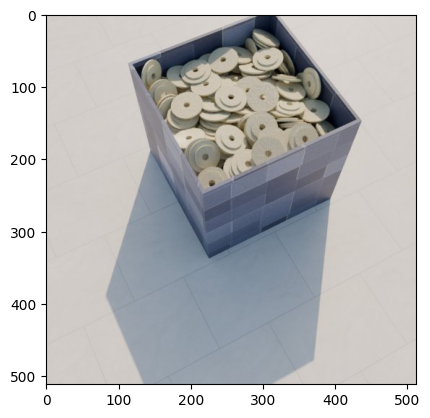

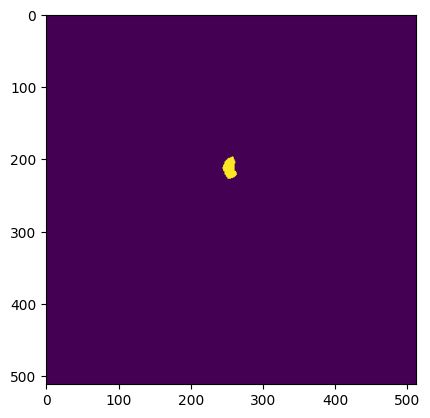

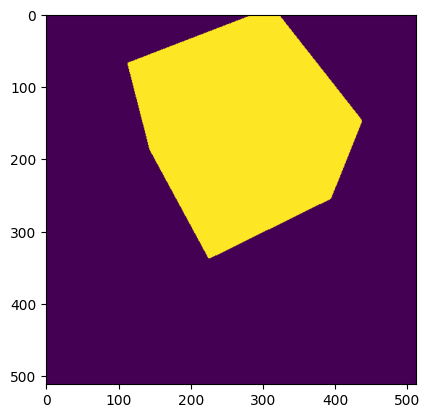

In [2]:
from PIL import Image, ImageDraw, ImageFont, ImageOps
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

data_dir = Path("../../../../projects/FRI/jn16867/3d-counting/scenes_part1")

category = "00002703_0"

path = data_dir / category / "geco2_data"

image = np.array(Image.open(path / "image.png").convert("RGB"))
obj_mask = np.array(Image.open(path / "obj_mask.png").convert("L"))
box_mask = np.array(Image.open(path / "box_mask.png").convert("L"))

plt.figure()
plt.imshow(image)
plt.show()

plt.figure()
plt.imshow(obj_mask)
plt.show()

plt.figure()
plt.imshow(box_mask)
plt.show()

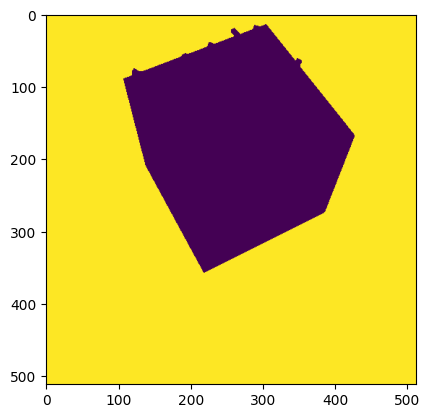

In [11]:
path = data_dir / category / "floor_seg" / "Ground_Mask0010.png"

mask = np.array(Image.open(path).convert("L"))

if type == "floor":
    mask = np.array(ImageOps.invert(mask))

mask = (mask > 0).astype(np.uint8) * 255

plt.figure()
plt.imshow(mask)
plt.show()

In [ ]:
path = data_dir / category / "geco2_data"

image = np.array(Image.open(path / "image").convert("RGB"))
obj_mask = np.array(Image.open(path / "obj_mask").convert("L"))
box_mask = np.array(Image.open(path / "box_mask").convert("L"))

plt.figure()
plt.imshow(image)
plt.show()

plt.figure()
plt.imshow(obj_mask)
plt.show()

plt.figure()
plt.imshow(box_mask)
plt.show()

In [ ]:

data_dir = Path("../../../../projects/FRI/jn16867/3d-counting/scenes_part1")

# Draw image with bounding boxes
category = "00004669_0"

image_path = data_dir / category / "obj_seg" / "Objects_Mask0010.png"
img_la = np.array(Image.open(image_path).convert("LA"))
img_draw = img_la[:,:,:-1].copy()

plt.figure()
plt.imshow(img_draw)
plt.show()

obj_seg = prepare_seg_image(data_dir, category, "obj_seg", "Objects_Mask0010.png")
    
bboxes = get_bounding_boxes_from_mask(obj_seg, data_dir / category, use_watershed=True)

for (x_min, y_min, x_max, y_max) in bboxes:
    cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
    
plt.figure()
plt.imshow(img_draw)
plt.axis('off')
plt.show()

NameError: name 'Path' is not defined

In [10]:
# Show each image with its bounding boxes
for category in os.listdir(data_dir):
    image_path = data_dir / category / "images" / "frame_00001.jpg"
    img_la = np.array(Image.open(image_path).convert("LA"))
    img_draw = img_la[:,:,:-1].copy()

    with open(data_dir / category / "generated_bboxes.txt", "r") as file:
        for line in file:
            bbox = [int(n) for n in line.strip().split(' ')]
            x_min, y_min, x_max, y_max = bbox
            cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
        
    plt.figure()
    plt.imshow(img_draw)
    plt.axis('off')
    plt.show()

In [27]:
def initial_process(ip_data, enable_mask_val, thr):
    # ip_data is a dict from ImagePrompter: {'image': np.ndarray, 'points': [...]}
    image, outputs, masks, img, scale, drawn_boxes = process_image_once(ip_data, enable_mask_val)
    out_img, n, masks_ori = post_process(image, outputs, masks, img, scale, drawn_boxes, enable_mask_val, thr)
    return (
        out_img, n, masks_ori,  # visible outputs
        image, outputs, masks, img, scale, drawn_boxes  # states
    )

In [28]:
def extract_mask_and_bbox(outputs, masks_tensor, image):
    # Extract output sam2 mask and best predicted bbox

    masks = np.array(masks_tensor.detach().cpu().numpy())
    scores = np.array(outputs[0]['scores'].detach().cpu().numpy())[0]
    
    N = min(len(scores), masks.shape[0])
    scores = scores[:N]
    masks = masks[:N, :, :]
    
    max_scores_ind = np.argmax(scores, axis=-1).item()

    # max_ind = np.argmax(np.array(outputs[0]['scores']), axis=-1).item()
    # top5_inds = np.argsort(scores[0])[-5:][::-1]

    mask = masks[max_scores_ind, :, :].astype(np.uint8) * 255

    bboxes_tensor = outputs[0]['pred_boxes'].squeeze(0).detach().cpu().numpy()
    bbox_norm = np.array(bboxes_tensor[max_scores_ind])

    H, W = image.shape[:2]

    x1 = int(bbox_norm[0] * W)
    y1 = int(bbox_norm[1] * H)
    x2 = int(bbox_norm[2] * W)
    y2 = int(bbox_norm[3] * H)

    bbox_px = np.array([x1, y1, x2, y2], dtype=np.int32)

    return mask, bbox_px

In [29]:
# Save the mask and the predicted bbox
def save_mask_and_bbox(save_dir, mask, bbox, image):
    os.makedirs(save_dir, exist_ok=True)

    np.save(save_dir / "image.npy", image)
    image_pil = Image.fromarray(image, mode="RGBA")
    image_pil.save(save_dir / "image.png")

    np.save(save_dir / "mask.npy", mask)
    mask_pil = Image.fromarray(mask, mode="L")
    mask_pil.save(save_dir / "mask.png")

    np.save(save_dir / "bbox.npy", bbox)

In [30]:
# Plot mask and bounding box
def plot_mask_and_bbox(image, mask, bbox):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(mask, cmap="gray")
    axs[0].set_title("Mask")
    axs[0].axis("off")

    img_vis = image.copy()

    cv2.rectangle(
        img_vis,
        (bbox[0], bbox[1]),
        (bbox[2], bbox[3]),
        color=(0, 255, 0),
        thickness=2
    )

    axs[1].imshow(img_vis)
    axs[1].set_title("Image + Bounding Box")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

In [15]:
from importlib import reload
import models.counter_infer as ci

reload(ci)

In [ ]:
# Run for single image in category
category = "00002254_2"

image_path = data_dir / category / "images" / "frame_00001.jpg"
img_rgba = np.array(Image.open(image_path).convert("RGBA"))

bboxes_file_path = data_dir / category / "generated_bboxes.txt"
points = []

with open(bboxes_file_path, "r") as file:
    for line in file:
        points.append([int(n) for n in line.strip().split(' ')])
        

input = {
    'image': img_rgba[:,:,:-1],
    'points': points
}
enable_mask = True
threshold = 0.5

out_img, n, masks_ori, image, outputs, masks, img, scale, drawn_boxes = initial_process(input, enable_mask, threshold)
    

In [31]:
data_dir = Path("../../../../projects/FRI/jn16867/3d-counting/scenes_part1")

# Run for single image in category
category = "00004669_0"

image_path = data_dir / category / "obj_seg" / "Objects_Mask0010.png"
img_rgba = np.array(Image.open(image_path).convert("RGBA"))
img_la = np.array(Image.open(image_path).convert("LA"))

obj_seg = prepare_seg_image(data_dir, category, "obj_seg", "Objects_Mask0010.png")  
bboxes = get_bounding_boxes_from_mask(obj_seg, data_dir / category, use_watershed=True)

bboxes_file_path = data_dir / category / "generated_bboxes.txt"
points = []

with open(bboxes_file_path, "r") as file:
    for line in file:
        points.append([int(n) for n in line.strip().split(' ')])
 
enable_mask = True
threshold = 0.5        
input = {
    'image': img_rgba[:,:,:-1],
    'points': points
}

out_img, n, masks_ori, image, outputs, masks, img, scale, drawn_boxes = initial_process(input, enable_mask, threshold)

/opt/conda/envs/geco2/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
mask, bbox = extract_mask_and_bbox(outputs, masks_ori, image)

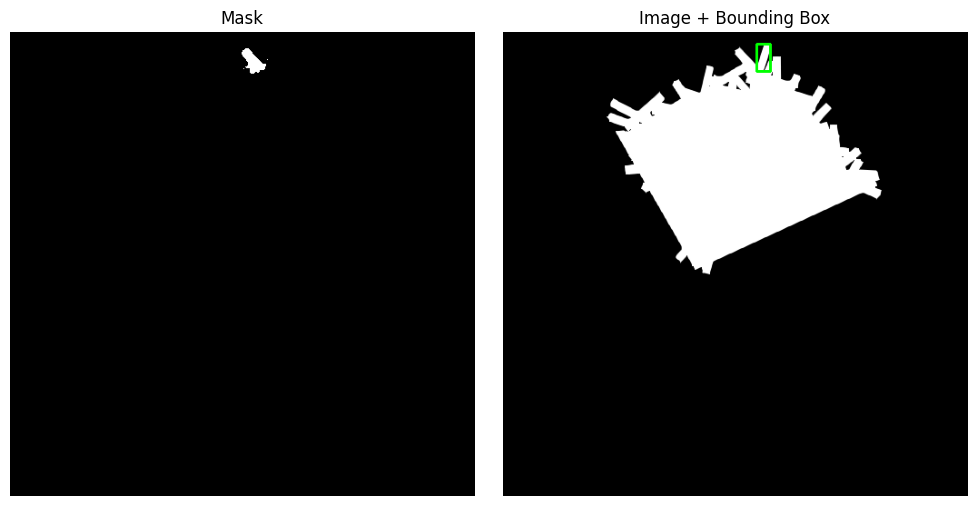

In [34]:
plot_mask_and_bbox(image, mask, bbox)

In [ ]:
import importlib
importlib.reload(inference)

In [17]:
# Run for an image in each category and save data

for category in os.listdir(data_dir):
    print(f"Processing category {category}")
    image_path = data_dir / category / "images" / "frame_00001.jpg"
    img_rgba = np.array(Image.open(image_path).convert("RGBA"))

    bboxes_file_path = data_dir / category / "generated_bboxes.txt"
    points = []

    with open(bboxes_file_path, "r") as file:
        for line in file:
            points.append([int(n) for n in line.strip().split(' ')])
    
    if len(points) == 0:
        print(f"No points found for category {category}, skipping")
        continue
    
    input = {
        'image': img_rgba[:,:,:-1],
        'points': points
    }
    enable_mask = True
    threshold = 0.5
    try:
        out_img, n, masks_ori_tensor, image, outputs, masks, img, scale, drawn_boxes = initial_process(input, enable_mask, threshold)
    except:
        print(f"Error processing category {category}")
    
    mask, bbox = extract_mask_and_bbox(outputs, masks_ori_tensor, image)
    
    save_dir = data_dir / category / "geco2_mask"
    save_mask_and_bbox(save_dir, mask, bbox, img_rgba)

In [43]:
sorted(os.listdir(data_dir / category / "obj_seg"))[len(os.listdir(data_dir / category / "obj_seg")) - 1]

'Objects_Mask0030.png'

In [46]:
os.path.exists(data_dir / category / "obj_seg" / "Objects_Mask0031.png")

False

In [ ]:
# Run for an image in each category and save data
data_dir = Path("../../../../projects/FRI/jn16867/3d-counting/scenes_part1")
num_empty_bboxes = 0

for category in os.listdir(data_dir):
    print(f"Processing category {category}")
    
    image_path = data_dir / category / "obj_seg" / "Objects_Mask0010.png"
    img_rgba = np.array(Image.open(image_path).convert("RGBA"))
    img_la = np.array(Image.open(image_path).convert("LA"))

    obj_seg = prepare_seg_image(data_dir, category, "obj_seg", "Objects_Mask0010.png")  
    bboxes = get_bounding_boxes_from_mask(obj_seg, data_dir / category, use_watershed=True)

    bboxes_file_path = data_dir / category / "generated_bboxes.txt"
    points = []

    with open(bboxes_file_path, "r") as file:
        for line in file:
            points.append([int(n) for n in line.strip().split(' ')])
        
    if len(points) == 0:
        print(f"No points found for category {category}, skipping")
        num_empty_bboxes = num_empty_bboxes + 1
        continue

    enable_mask = True
    threshold = 0.5        
    input = {
        'image': img_rgba[:,:,:-1],
        'points': points
    }

    try:
        out_img, n, masks_ori_tensor, image, outputs, masks, img, scale, drawn_boxes = initial_process(input, enable_mask, threshold)
    except:
        print(f"Error processing category {category}")
    
    mask, bbox = extract_mask_and_bbox(outputs, masks_ori_tensor, image)
    
    save_dir = data_dir / category / "geco2_mask"
    save_mask_and_bbox(save_dir, mask, bbox, img_rgba)
    
print(f"{num_empty_bboxes} categories with no bboxes found")